In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import requests
import seaborn as sns

from dotenv import load_dotenv
from functools import reduce
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, log_loss
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler
from sklearn.svm import SVC, SVR
from xgboost import XGBClassifier, XGBRegressor, plot_importance

%matplotlib inline
plt.style.use("ggplot")
sns.set_context("talk")

In [2]:
load_dotenv("")
FREDkey = os.getenv("FREDkey")

In [3]:
varlist = ["WILL5000INDFC",
           "NIKKEI225",
           "CPIAUCSL",
           "CPIFABSL",
           "CPIHOSSL",
           "IC4WSA",
           "INDPRO",
           "IPMAN",
           "HOUST",
           "HSN1F",
           "RELACBW027SBOG",
           "MSPNHSUS",
           "USSTHPI",
           "AHETPI",
           "PCE",
           "PCEND",
           "DAUTOSAAR",
           "PI",
           "A229RX0",
           "DEXJPUS",
           "DTWEXM",
           "DGS30",
           "DGS10",
           "DGS2",
           "DGS5",
           "DTB3",
           "MORTGAGE30US",
           "AAA",
           "BAA",
           "BAMLCC0A0CMTRIV",
           "FEDFUNDS",
           "TB3SMFFM",
           "UMCSENT",  
           "CIVPART",
           "TCU",
           "UNRATE",
           "LNS14000002",
           "LNS15000000",
           "UEMPMEAN",
           "USCONS",
           "NFCI",
           "USRECDM",
           "GDPPOT",
           "GDPC1",
           "GOLDPMGBD228NLBM",
           "WTISPLC",
           "CMRMTSPL",
           "TERMCBAUTO48NS",
           "TERMCBPER24NS",
           "NONREVSL",
           "CEFDFSA066MSFRBPHI",
           "M1SL",
           "MABMM301USM189S",
           "TOTALSA",
           "PSAVERT",
           "TOTCI",
           "TOTLL",
           "TOTBKCR",
           "DPRIME",
           "MSACSR",
           "PPIACO",
           "PERMIT",
           "DSPIC96",
           "TLAACBW027SBOG",
           "M12MTVUSM227NFWA",
           "AWHMAN",
           "CCSA",
           "TCD",
           "CSCICP03USM665S"
          ]

In [4]:
datalist=[]
for var in varlist:
    resp = requests.get(
        "https://api.stlouisfed.org/fred/series/observations?series_id={}&api_key={}&file_type=json"
        .format(var, 
                FREDkey))
    df = pd.DataFrame(resp.json()['observations'])
    df.date = pd.to_datetime(df.date)
    df = df.loc[df.value!="."]
    df.value = df.value.astype(float)
    df.index = df.date
    df.drop(columns=["realtime_end", "realtime_start", "date"], axis=1, inplace=True)
    df.columns=[var]
    df= df.resample("1D").interpolate(method='linear')
    datalist.append(df)

In [5]:
df_merged = reduce(lambda left, right: pd.merge(left, right, on='date', how='outer'), datalist)

In [6]:
df_merged.shape

(63858, 69)

In [7]:
df_merged["2-10"] = df_merged.DGS10 - df_merged.DGS2
df_merged["10-30"] = df_merged.DGS30 - df_merged.DGS10
df_merged["positive_gap"] = df_merged.GDPC1.pct_change(365) - df_merged.GDPPOT.pct_change(365) > 0
df_merged["gap"] = df_merged.GDPC1.pct_change(365) - df_merged.GDPPOT.pct_change(365)
df_WILL5000_5d_vol = df_merged.WILL5000INDFC.pct_change(1).rolling(5).std()
df_WILL5000_30d_vol = df_merged.WILL5000INDFC.pct_change(1).rolling(30).std()

In [8]:
df_WILL5000_5d_vol= df_WILL5000_5d_vol.loc[df_merged.DGS30>-10].resample("1W").mean()
df_WILL5000_30d_vol= df_WILL5000_30d_vol.loc[df_merged.DGS30>-10].resample("1W").mean()
df_merged = df_merged.loc[df_merged.DGS30>-10].resample("1W").mean()

In [9]:
percent = ["WILL5000INDFC",
           "NIKKEI225",
           "CPIAUCSL", 
           "CPIFABSL",
           "CPIHOSSL",
           "IC4WSA",
           "INDPRO",
           "IPMAN",
           "HOUST",
           "HSN1F",
           "RELACBW027SBOG",
           "MSPNHSUS",
           "USSTHPI",
           "AHETPI",
           "PCE",
           "PCEND",
           "DAUTOSAAR",
           "A229RX0",
           "DEXJPUS",
           "DTWEXM",
           "GOLDPMGBD228NLBM",
           "WTISPLC",
           "BAMLCC0A0CMTRIV",
           "CMRMTSPL",
           "NONREVSL",
           "M1SL",
           "MABMM301USM189S",
           "TOTALSA",
           "TOTCI",
           "TOTLL",
           "TOTBKCR",
           "PPIACO",
           "PERMIT",
           "DSPIC96",
           "TLAACBW027SBOG",
           "M12MTVUSM227NFWA",
           "PI",
           "AWHMAN",
           "CCSA",
           "TCD",
           "UEMPMEAN",
           "LNS15000000",
           "USCONS"
          ]

In [10]:
actual = ["DGS30",
          "DGS10",
          "DGS2",
          "DGS5",
          "DTB3",
          "MORTGAGE30US",
          "AAA",
          "BAA",
          "FEDFUNDS",
          "TB3SMFFM",
          "UMCSENT",  
          "CIVPART",
          "TCU",
          "UNRATE",
          "LNS14000002",
          "NFCI",
          "2-10",
          "10-30",
          "gap",
          "TERMCBAUTO48NS",
          "TERMCBPER24NS",
          "CEFDFSA066MSFRBPHI",
          "PSAVERT",
          "DPRIME",
          "MSACSR",
          "CSCICP03USM665S"
         ]

In [11]:
def change(df, percent, actual, period):
    df_actual = df[actual].diff(period).fillna(method='ffill')

    df_percent = df[percent].pct_change(period).fillna(method='ffill')
    df_concat = pd.concat([df_actual, df_percent], axis=1)
    df_concat.columns = [str(col) + '_{}'.format(period) for col in df_concat.columns]
    return df_concat

In [12]:
week = change(df_merged, percent, actual, 1)
week_week = week.diff(1).add_suffix("_1")
month = change(df_merged, percent, actual, 4)
month_month = month.diff(4).add_suffix("_4")
three_m = change(df_merged, percent, actual, 13)
three_three = three_m.diff(13).add_suffix("_13")
six_m = change(df_merged, percent, actual, 26)
six_six = six_m.diff(26).add_suffix("_26")
one_y = change(df_merged, percent, actual, 52)

In [13]:
X = pd.concat([week, 
               week_week, 
               month, 
               month_month, 
               three_m, 
               three_three, 
               six_m, 
               six_six, 
               one_y,
               df_merged[actual].fillna(method="ffill"),
               df_merged[actual].fillna(method="ffill").shift(1),
               df_merged[actual].fillna(method="ffill").shift(4),
               df_merged[actual].fillna(method="ffill").shift(13),
               df_merged[actual].fillna(method="ffill").shift(26),
               df_merged[actual].fillna(method="ffill").shift(52),
               df_WILL5000_5d_vol,
               df_WILL5000_30d_vol
              ], axis=1)[52:]

In [14]:
# X = pd.concat([week, 
#                week_week, 
#                month, 
#                month_month, 
#                three_m, 
#                three_three, 
#                six_m, 
#                six_six, 
#                one_y,
#               ], axis=1)[52:]

In [15]:
y1w = df_merged.positive_gap.shift(-1)[X.index].fillna(method="ffill").apply(lambda x: 1 if x>0.5 else 0)
y1m = df_merged.positive_gap.shift(-4)[X.index].fillna(method="ffill").apply(lambda x: 1 if x>0.5 else 0)
y3m = df_merged.positive_gap.shift(-13)[X.index].fillna(method="ffill").apply(lambda x: 1 if x>0.5 else 0)
y6m = df_merged.positive_gap.shift(-26)[X.index].fillna(method="ffill").apply(lambda x: 1 if x>0.5 else 0)
y12m = df_merged.positive_gap.shift(-52)[X.index].fillna(method="ffill").apply(lambda x: 1 if x>0.5 else 0)

In [16]:
# GDPC1y1w = df_merged.USREC.shift(-1)[X.index].fillna(method="ffill").apply(lambda x: 1 if x>0.5 else 0)
# y1m = df_merged.USREC.shift(-4)[X.index].fillna(method="ffill").apply(lambda x: 1 if x>0.5 else 0)
# y3m = df_merged.USREC.shift(-13)[X.index].fillna(method="ffill").apply(lambda x: 1 if x>0.5 else 0)
# y6m = df_merged.USREC.shift(-26)[X.index].fillna(method="ffill").apply(lambda x: 1 if x>0.5 else 0)
# y12m = df_merged.USREC.shift(-52)[X.index].fillna(method="ffill").apply(lambda x: 1 if x>0.5 else 0)

In [17]:
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X))

In [18]:
X.isnull().sum().sort_values(ascending=False)

WILL5000INDFC             0
RELACBW027SBOG_4_4        0
PERMIT_4_4                0
PPIACO_4_4                0
TOTBKCR_4_4               0
TOTLL_4_4                 0
TOTCI_4_4                 0
TOTALSA_4_4               0
MABMM301USM189S_4_4       0
M1SL_4_4                  0
NONREVSL_4_4              0
CMRMTSPL_4_4              0
BAMLCC0A0CMTRIV_4_4       0
WTISPLC_4_4               0
GOLDPMGBD228NLBM_4_4      0
DTWEXM_4_4                0
DEXJPUS_4_4               0
A229RX0_4_4               0
DAUTOSAAR_4_4             0
PCEND_4_4                 0
PCE_4_4                   0
AHETPI_4_4                0
USSTHPI_4_4               0
DSPIC96_4_4               0
TLAACBW027SBOG_4_4        0
M12MTVUSM227NFWA_4_4      0
DTB3_13                   0
UNRATE_13                 0
TCU_13                    0
CIVPART_13                0
                         ..
UMCSENT_26_26             0
TB3SMFFM_26_26            0
FEDFUNDS_26_26            0
BAA_26_26                 0
AAA_26_26           

In [19]:
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

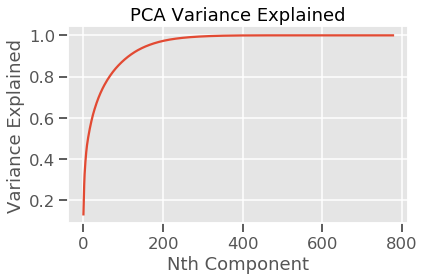

In [20]:
plt.plot(pca.explained_variance_ratio_.cumsum())
plt.title("PCA Variance Explained")
plt.xlabel("Nth Component")
plt.ylabel("Variance Explained")
plt.tight_layout()
plt.savefig("../images/pca")

In [21]:
n_pc = 150

In [22]:
X_train = X_pca[:int(X_pca.shape[0]*0.7), :n_pc]
X_test = X_pca[int(X_pca.shape[0]*0.7):, :n_pc]

In [23]:
X_train.shape

(1520, 150)

In [24]:
y1w.shape

(2172,)

In [25]:
y1w_train = y1w[:int(X_pca.shape[0]*0.7)]
y1w_test = y1w[int(X_pca.shape[0]*0.7):]

In [26]:
clf = SVC(C=0.1, gamma=0.001, probability=True)
clf.fit(X_train, y1w_train)
confusion_matrix(clf.predict(X_test), y1w_test)

array([[121,  27],
       [107, 397]])

In [27]:
clf.score(X_train, y1w_train)

0.8973684210526316

In [28]:
clf.score(X_test, y1w_test)

0.7944785276073619

/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


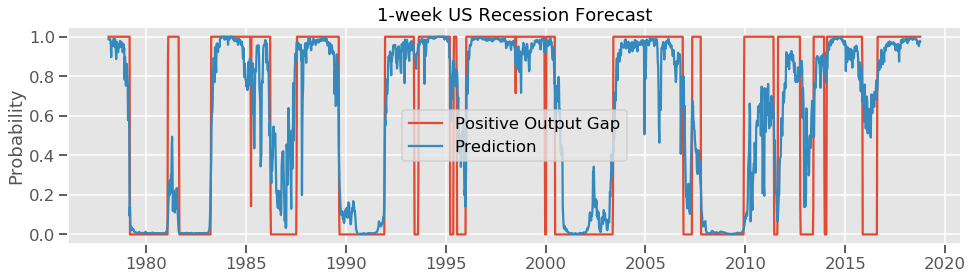

In [29]:
pred = pd.DataFrame(clf.predict_proba(X_pca[:, :n_pc])[:, 1])
pred.set_index(X.index, inplace=True)
pred.columns = ["pred"]
fig = plt.figure(figsize=(16,4))
ax = plt.plot(pd.merge(df_merged.positive_gap[X_scaled.index], pred, on="date"))
plt.title("1-week US Recession Forecast")
plt.ylabel("Probability")
plt.legend(["Positive Output Gap", "Prediction"])
plt.savefig("../images/1w_gap_svc")
plt.show()

In [30]:
y1m_train = y1m[:int(X_pca.shape[0]*0.7)]
y1m_test = y1m[int(X_pca.shape[0]*0.7):]

In [31]:
clf = SVC(C=20, gamma=0.00001, probability=True)
clf.fit(X_train, y1m_train)
print(confusion_matrix(clf.predict(X_test), y1m_test))
print("train:", clf.score(X_train, y1m_train))
print("test", clf.score(X_test, y1m_test))

[[122  39]
 [106 385]]
train: 0.9532894736842106
test 0.7776073619631901


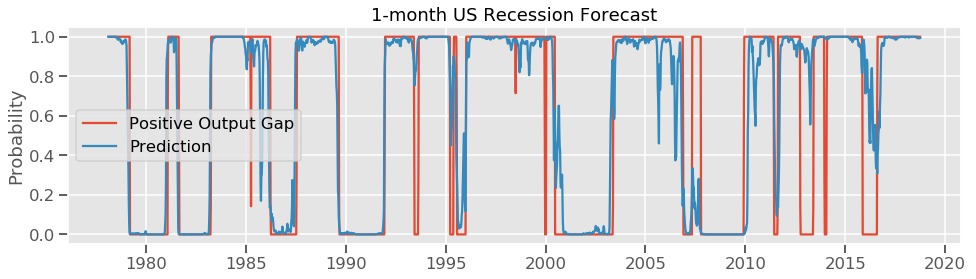

In [32]:
pred = pd.DataFrame(clf.predict_proba(X_pca[:, :n_pc])[:, 1])
pred.set_index(X.index, inplace=True)
pred.columns = ["pred"]
fig = plt.figure(figsize=(16,4))
ax = plt.plot(pd.merge(df_merged.positive_gap[X_scaled.index], pred, on="date"))
plt.title("1-month US Recession Forecast")
plt.ylabel("Probability")
plt.legend(["Positive Output Gap", "Prediction"])
plt.savefig("../images/1m_gap_svc")
plt.show()

In [33]:
y3m_train = y3m[:int(X_pca.shape[0]*0.7)]
y3m_test = y3m[int(X_pca.shape[0]*0.7):]

In [34]:
clf = SVC(C=20, gamma=0.00001, probability=True)
clf.fit(X_train, y3m_train)
print(confusion_matrix(clf.predict(X_test), y3m_test))
print("train:", clf.score(X_train, y3m_train))
print("test", clf.score(X_test, y3m_test))

[[111  12]
 [126 403]]
train: 0.9552631578947368
test 0.7883435582822086


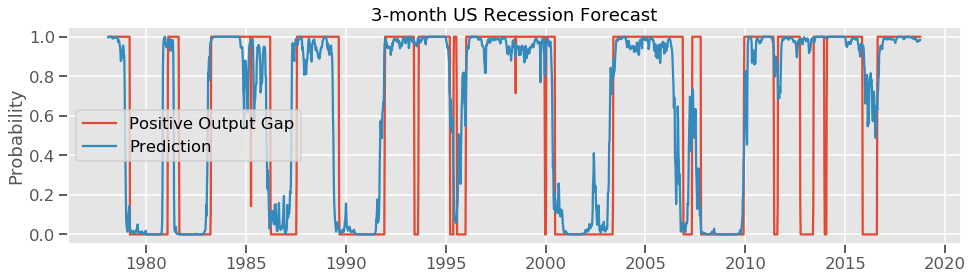

In [35]:
pred = pd.DataFrame(clf.predict_proba(X_pca[:, :n_pc])[:, 1])
pred.set_index(X.index, inplace=True)
pred.columns = ["pred"]
fig = plt.figure(figsize=(16,4))
ax = plt.plot(pd.merge(df_merged.positive_gap[X_scaled.index], pred, on="date"))
plt.title("3-month US Recession Forecast")
plt.ylabel("Probability")
plt.legend(["Positive Output Gap", "Prediction"])
plt.savefig("../images/3m_gap_svc")
plt.show()

In [36]:
clf = RandomForestClassifier(max_features=120, 
                             n_estimators=60, 
                             max_depth=8, 
                             min_samples_leaf=100, 
                             random_state=0,
                             class_weight="balanced"
                            )
clf.fit(X_train, y3m_train)
print(confusion_matrix(clf.predict(X_test), y3m_test))
print("train:", clf.score(X_train, y3m_train))
print("test", clf.score(X_test, y3m_test))

[[228 249]
 [  9 166]]
train: 0.8157894736842105
test 0.6042944785276073


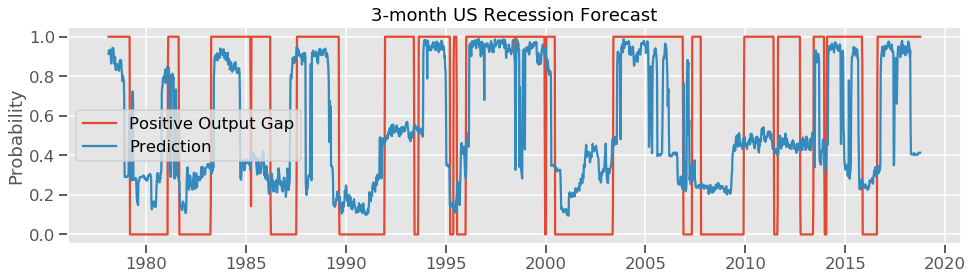

In [37]:
pred = pd.DataFrame(clf.predict_proba(X_pca[:, :n_pc])[:, 1])
pred.set_index(X.index, inplace=True)
pred.columns = ["pred"]
fig = plt.figure(figsize=(16,4))
ax = plt.plot(pd.merge(df_merged.positive_gap[X_scaled.index], pred, on="date"))
plt.title("3-month US Recession Forecast")
plt.ylabel("Probability")
plt.legend(["Positive Output Gap", "Prediction"])
plt.savefig("../images/3m_gap_rfc")
plt.show()

In [38]:
y6m_train = y6m[:int(X_pca.shape[0]*0.7)]
y6m_test = y6m[int(X_pca.shape[0]*0.7):]

In [39]:
clf = SVC(C=35,
          gamma=0.00001,
          probability=True)
clf.fit(X_train, y6m_train)
print(confusion_matrix(clf.predict(X_test), y6m_test))
print(clf.score(X_train, y6m_train))
print(clf.score(X_test, y6m_test))

[[ 76   4]
 [174 398]]
0.95
0.7269938650306749


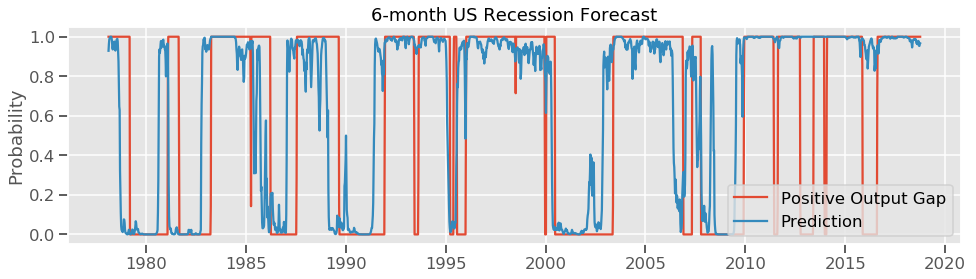

In [40]:
pred = pd.DataFrame(clf.predict_proba(X_pca[:, :n_pc])[:, 1])
pred.set_index(X.index, inplace=True)
pred.columns = ["pred"]
fig = plt.figure(figsize=(16,4))
ax = plt.plot(pd.merge(df_merged.positive_gap[X_scaled.index], pred, on="date"))
plt.title("6-month US Recession Forecast")
plt.ylabel("Probability")
plt.legend(["Positive Output Gap", "Prediction"], loc=4)
plt.savefig("../images/6m_gap_svc")
plt.show()

In [41]:
clf = RandomForestClassifier(max_features=100, 
                             n_estimators=30, 
                             max_depth=8, 
                             min_samples_leaf=100, 
                             random_state=0,
                             class_weight="balanced"
                            )
clf.fit(X_train, y6m_train)
print(confusion_matrix(clf.predict(X_test), y6m_test))
print(clf.score(X_train, y6m_train))
print(clf.score(X_test, y6m_test))

[[163  40]
 [ 87 362]]
0.8401315789473685
0.8052147239263804


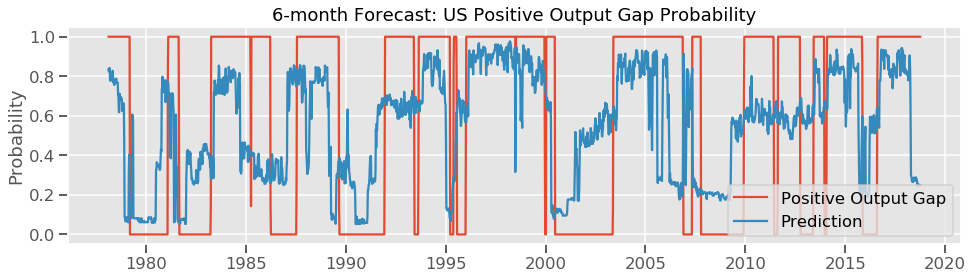

In [42]:
pred = pd.DataFrame(clf.predict_proba(X_pca[:, :n_pc])[:, 1])
pred.set_index(X.index, inplace=True)
pred.columns = ["pred"]
fig = plt.figure(figsize=(16,4))
ax = plt.plot(pd.merge(df_merged.positive_gap[X_scaled.index], pred, on="date"))
plt.title("6-month Forecast: US Positive Output Gap Probability")
plt.ylabel("Probability")
plt.legend(["Positive Output Gap", "Prediction"], loc=4)
plt.savefig("../images/6m_gap_rfc")
plt.show()

In [43]:
y12m_train = y12m[:int(X_pca.shape[0]*0.7)]
y12m_test = y12m[int(X_pca.shape[0]*0.7):]

[[160  57]
 [ 90 345]]
0.8269736842105263
0.7745398773006135


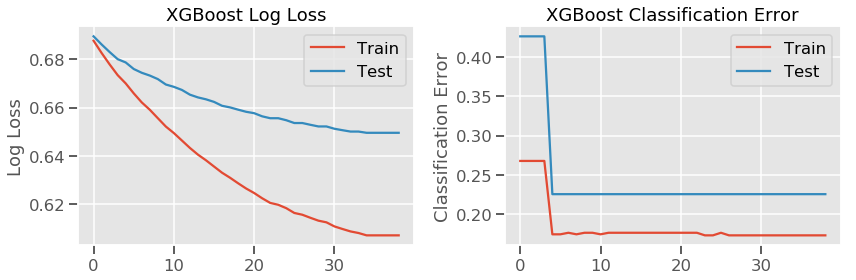

In [44]:
clf = XGBClassifier(max_depth=2, 
                    learning_rate=0.1, 
                    n_estimators=200,
                    gamma=1,
                    random_state=0,
                    scale_pos_weight=y6m_train.value_counts()[0]/y6m_train.value_counts()[1],
                    reg_alpha=100,
                    reg_lambda=100
                   )
clf.fit(X_train, 
        y6m_train, 
        eval_set = [(X_train, y6m_train), (X_test, y6m_test)],
        eval_metric=["error", "logloss"],
        early_stopping_rounds=5,
        verbose=False
       )
print(confusion_matrix(clf.predict(X_test), y6m_test))
print(clf.score(X_train, y6m_train))
print(clf.score(X_test, y6m_test))

# retrieve performance metrics
results = clf.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
ax[0].plot(x_axis, results['validation_0']['logloss'], label='Train')
ax[0].plot(x_axis, results['validation_1']['logloss'], label='Test')
ax[0].legend()
ax[0].set_ylabel('Log Loss')
ax[0].set_title('XGBoost Log Loss')
# plot classification error
ax[1].plot(x_axis, results['validation_0']['error'], label='Train')
ax[1].plot(x_axis, results['validation_1']['error'], label='Test')
ax[1].legend()
ax[1].set_ylabel('Classification Error')
ax[1].set_title('XGBoost Classification Error')
plt.tight_layout()
plt.show()

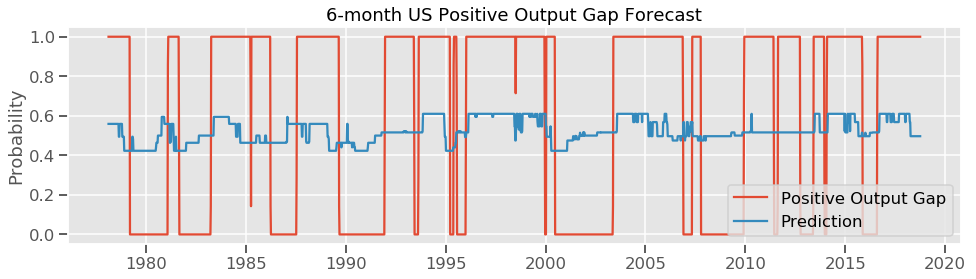

In [45]:
pred = pd.DataFrame(clf.predict_proba(X_pca[:, :n_pc])[:, 1])
pred.set_index(X.index, inplace=True)
pred.columns = ["pred"]
fig = plt.figure(figsize=(16,4))
ax = plt.plot(pd.merge(df_merged.positive_gap[X_scaled.index], pred, on="date"))
plt.title("6-month US Positive Output Gap Forecast")
plt.ylabel("Probability")
plt.legend(["Positive Output Gap", "Prediction"], loc=4)
plt.savefig("../images/6m_gap_xgc")
plt.show()

In [46]:
xgc_scores = {}
xgc_feature_sets = []
k=0
for i in range(0, 100, 10):
    for j in range(0, 100, 10):
        xgc = XGBClassifier(reg_alpha=i, reg_lambda=j)
        xgc.fit(X_train,
                y6m_train,
                eval_set = [(X_train, y6m_train), (X_test, y6m_test)],
                eval_metric=["error", "logloss"],
                early_stopping_rounds=5,
                verbose=False)

        
        xgc_features = pd.DataFrame(xgc.feature_importances_, 
                                    columns=["importance"]
                                   ).sort_values(by="importance",
                                                 ascending=False) 
                                
        xgc_scores[k] = [i,
                         j,
                         clf.evals_result()['validation_0']['logloss'][-1],
                         clf.evals_result()['validation_1']['logloss'][-1],
                         clf.evals_result()['validation_0']['error'][-1],
                         clf.evals_result()['validation_1']['error'][-1],
                         np.sum(xgc_features.importance>0)]
        xgc_feature_sets.append(xgc_features)
        k += 1
        if k%10 ==0:
            print("Progress: {}% completed".format(k))

Progress: 10% completed
Progress: 20% completed
Progress: 30% completed
Progress: 40% completed
Progress: 50% completed
Progress: 60% completed
Progress: 70% completed
Progress: 80% completed
Progress: 90% completed
Progress: 100% completed


In [47]:
xgc_reg_score = pd.DataFrame(xgc_scores, 
                             index=["alpha",
                                    "lambda",
                                    "train_log_loss",
                                    "test_log_loss",
                                    "train_error",
                                    "test_error",
                                    "n_features"
                                   ]).T

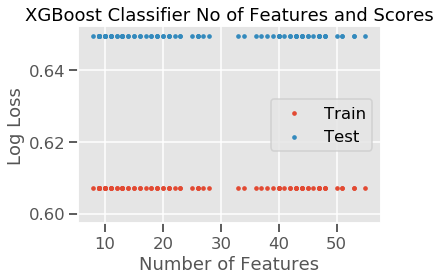

In [48]:
plt.scatter(xgc_reg_score.n_features, 
            xgc_reg_score.train_log_loss,
            s=10
           )
plt.scatter(xgc_reg_score.n_features,
            xgc_reg_score.test_log_loss,
            s=10
           )
plt.title("XGBoost Classifier No of Features and Scores")
plt.ylabel("Log Loss")
plt.xlabel("Number of Features")
plt.legend(["Train","Test"])
plt.tight_layout()
plt.savefig("../images/output_gap_xgc_reg_log_loss_6m")

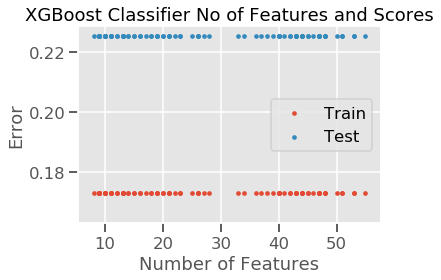

In [49]:
plt.scatter(xgc_reg_score.n_features, 
            xgc_reg_score.train_error,
            s=10
           )
plt.scatter(xgc_reg_score.n_features,
            xgc_reg_score.test_error,
            s=10
           )
plt.title("XGBoost Classifier No of Features and Scores")
plt.ylabel("Error")
plt.xlabel("Number of Features")
plt.legend(["Train","Test"])
plt.tight_layout()
plt.savefig("../images/output_gap_xgc_reg_error_6m")

In [50]:
y12m_train = y12m[:int(X_pca.shape[0]*0.7)]
y12m_test = y12m[int(X_pca.shape[0]*0.7):]

In [51]:
clf = SVC(C=100, 
          gamma=0.000005, 
          probability=True,
          random_state=0,
          class_weight="balanced"
         )
clf.fit(X_train, y12m_train)
print(confusion_matrix(clf.predict(X_test), y12m_test))
print("train:", clf.score(X_train, y12m_train))
print("test:", clf.score(X_test, y12m_test))

[[102  29]
 [149 372]]
train: 0.9269736842105263
test: 0.7269938650306749


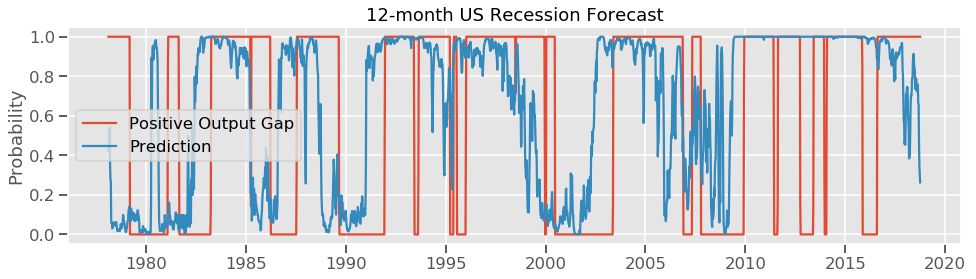

In [52]:
pred = pd.DataFrame(clf.predict_proba(X_pca[:, :n_pc])[:, 1])
pred.set_index(X.index, inplace=True)
pred.columns = ["pred"]
fig = plt.figure(figsize=(16,4))
ax = plt.plot(pd.merge(df_merged.positive_gap[X_scaled.index], pred, on="date"))
plt.title("12-month US Recession Forecast")
plt.ylabel("Probability")
plt.legend(["Positive Output Gap", "Prediction"])
plt.savefig("../images/12m_gap_svc")
plt.show()

In [53]:
y12m_train.value_counts()[1]/y12m_train.value_counts()[0]

1.4555735056542811

In [54]:
clf = RandomForestClassifier(max_features=100, 
                             n_estimators=70, 
                             max_depth=30, 
                             min_samples_leaf=50,
                             random_state=0, 
                             class_weight="balanced"
                            )
clf.fit(X_train, 
        y12m_train)
print(confusion_matrix(clf.predict(X_test), y12m_test))
print("train:", clf.score(X_train, y12m_train))
print("test:", clf.score(X_test, y12m_test))

[[113  23]
 [138 378]]
train: 0.8736842105263158
test: 0.7530674846625767


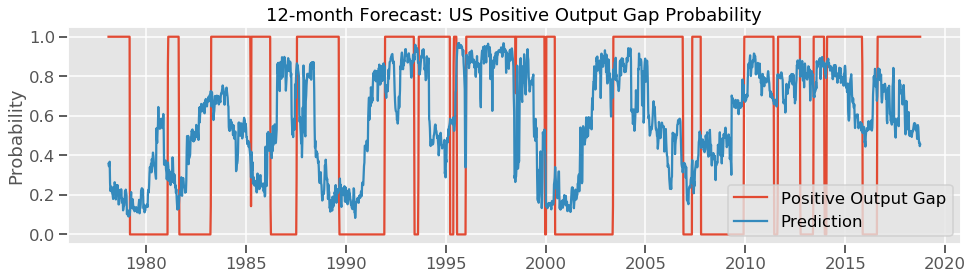

In [55]:
pred = pd.DataFrame(clf.predict_proba(X_pca[:, :n_pc])[:, 1])
pred.set_index(X.index, inplace=True)
pred.columns = ["pred"]
fig = plt.figure(figsize=(16,4))
ax = plt.plot(pd.merge(df_merged.positive_gap[X_scaled.index], pred, on="date"))
plt.title("12-month Forecast: US Positive Output Gap Probability")
plt.ylabel("Probability")
plt.legend(["Positive Output Gap", "Prediction"], loc=4)
plt.savefig("../images/12m_gap_rfc")
plt.show()

[[ 84   0]
 [167 401]]
train: 0.7743421052631579
test: 0.7438650306748467


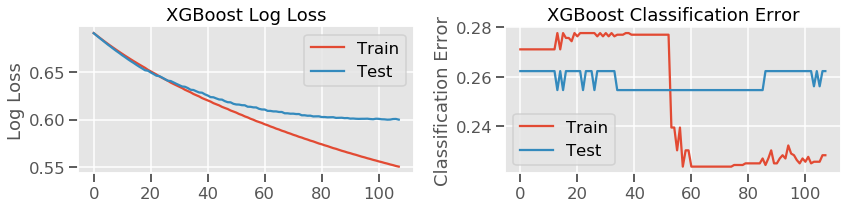

In [56]:
clf = XGBClassifier(max_depth=2, 
                    learning_rate=0.01, 
                    n_estimators=200,
                    gamma=1,
                    scale_pos_weight=y6m_train.value_counts()[0]/y6m_train.value_counts()[1]
                   )
clf.fit(X_train, 
        y12m_train, 
        eval_set = [(X_train, y12m_train), (X_test, y12m_test)],
        eval_metric=["error", "logloss"],
        early_stopping_rounds=5,
        verbose=False
       )
print(confusion_matrix(clf.predict(X_test), y12m_test))
print("train:", clf.score(X_train, y12m_train))
print("test:", clf.score(X_test, y12m_test))

# retrieve performance metrics
results = clf.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,3))
ax[0].plot(x_axis, results['validation_0']['logloss'], label='Train')
ax[0].plot(x_axis, results['validation_1']['logloss'], label='Test')
ax[0].legend()
ax[0].set_ylabel('Log Loss')
ax[0].set_title('XGBoost Log Loss')
# plot classification error
ax[1].plot(x_axis, results['validation_0']['error'], label='Train')
ax[1].plot(x_axis, results['validation_1']['error'], label='Test')
ax[1].legend()
ax[1].set_ylabel('Classification Error')
ax[1].set_title('XGBoost Classification Error')
plt.tight_layout()
plt.show()

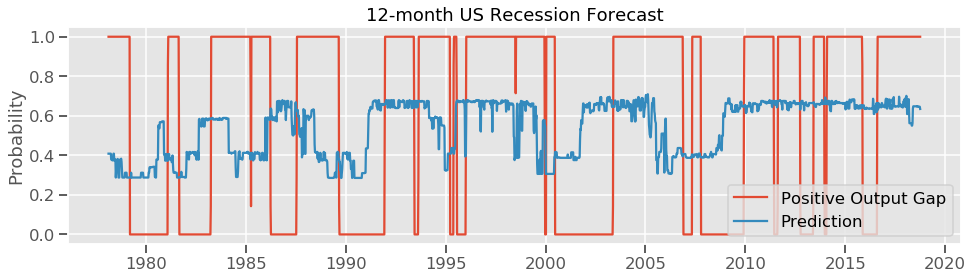

In [57]:
pred = pd.DataFrame(clf.predict_proba(X_pca[:, :n_pc])[:, 1])
pred.set_index(X.index, inplace=True)
pred.columns = ["pred"]
fig = plt.figure(figsize=(16,4))
ax = plt.plot(pd.merge(df_merged.positive_gap[X_scaled.index], pred, on="date"))
plt.title("12-month US Recession Forecast")
plt.ylabel("Probability")
plt.legend(["Positive Output Gap", "Prediction"], loc=4)
plt.savefig("../images/12m_gap_xgc")
plt.show()

In [58]:
xgc_scores = {}
xgc_feature_sets = []
k=0
for i in range(0, 100, 10):
    for j in range(0, 100, 10):
        xgc = XGBClassifier(reg_alpha=i, reg_lambda=j)
        xgc.fit(X_train, y12m_train)

        
        xgc_features = pd.DataFrame(xgc.feature_importances_, 
                                    columns=["importance"]
                                   ).sort_values(by="importance",
                                                 ascending=False) 
                                
        xgc_scores[k] = [i,
                         j,
                         xgc.score(X_train, y12m_train),
                         xgc.score(X_test, y12m_test),
                         np.sum(xgc_features.importance>0)]
        xgc_feature_sets.append(xgc_features)
        k += 1

In [59]:
xgc_reg_score = pd.DataFrame(xgc_scores, 
                             index=["alpha",
                                    "lambda",
                                    "train",
                                    "test",
                                    "n_features"
                                   ]).T

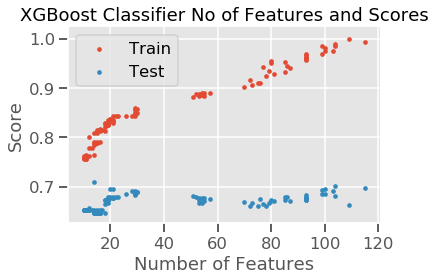

In [60]:
plt.scatter(xgc_reg_score.n_features, 
            xgc_reg_score.train,
            s=10
           )
plt.scatter(xgc_reg_score.n_features,
            xgc_reg_score.test,
            s=10
           )
plt.title("XGBoost Classifier No of Features and Scores")
plt.ylabel("Score")
plt.xlabel("Number of Features")
plt.legend(["Train","Test"])
plt.tight_layout()
plt.savefig("../images/output_gap_xgc_reg_score_12m")

In [63]:
actual = ["DGS30",
          "DGS10",
          "DGS2",
          "DGS5",
          "DTB3",
          "MORTGAGE30US",
          "AAA",
          "BAA",
          "FEDFUNDS",
          "TB3SMFFM",
          "UMCSENT",  
          "CIVPART",
          "TCU",
          "UNRATE",
          "LNS14000002",
          "NFCI",
          "2-10",
          "10-30",
#           "gap",
          "TERMCBAUTO48NS",
          "TERMCBPER24NS",
          "CEFDFSA066MSFRBPHI",
          "PSAVERT",
          "DPRIME",
          "MSACSR",
          "CSCICP03USM665S"
         ]

In [64]:
week = change(df_merged, percent, actual, 1)
week_week = week.diff(1).add_suffix("_1")
month = change(df_merged, percent, actual, 4)
month_month = month.diff(4).add_suffix("_4")
three_m = change(df_merged, percent, actual, 13)
three_three = three_m.diff(13).add_suffix("_13")
six_m = change(df_merged, percent, actual, 26)
six_six = six_m.diff(26).add_suffix("_26")
one_y = change(df_merged, percent, actual, 52)

In [65]:
X = pd.concat([week, 
               week_week, 
               month, 
               month_month, 
               three_m, 
               three_three, 
               six_m, 
               six_six, 
               one_y,
               df_merged[actual].fillna(method="ffill"),
               df_merged[actual].fillna(method="ffill").shift(1),
               df_merged[actual].fillna(method="ffill").shift(4),
               df_merged[actual].fillna(method="ffill").shift(13),
               df_merged[actual].fillna(method="ffill").shift(26),
               df_merged[actual].fillna(method="ffill").shift(52),
               df_WILL5000_5d_vol,
               df_WILL5000_30d_vol
              ], axis=1)[52:]

In [66]:
X_gap = pd.concat([df_merged.gap,
#                    pd.DataFrame(df_merged.gap.diff(1)).add_suffix("_diff"),
#                    pd.DataFrame(df_merged.gap.diff(1).diff(1)).add_suffix("_diff_diff")
                  ], axis=1)[52:]

In [67]:
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X))

In [68]:
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

In [69]:
X_pca_gap = np.concatenate([np.array(X_gap), X_pca], axis=1)

In [70]:
X_pca_gap.shape

(2172, 765)

In [71]:
n_pc = 150

In [72]:
X_train_gap = X_pca_gap[:int(X_pca.shape[0]*0.7), :n_pc]
X_test_gap = X_pca_gap[int(X_pca.shape[0]*0.7):, :n_pc]

In [73]:
X_train.shape

(1520, 150)

In [74]:
g1w = df_merged.gap.shift(-1)[X.index].fillna(method="ffill")
g1m = df_merged.gap.shift(-4)[X.index].fillna(method="ffill")
g3m = df_merged.gap.shift(-13)[X.index].fillna(method="ffill")
g6m = df_merged.gap.shift(-26)[X.index].fillna(method="ffill")
g12m = df_merged.gap.shift(-52)[X.index].fillna(method="ffill")

In [75]:
g6m_train = g6m[:int(X_pca.shape[0]*0.7)]
g6m_test = g6m[int(X_pca.shape[0]*0.7):]
g12m_train = g12m[:int(X_pca.shape[0]*0.7)]
g12m_test = g12m[int(X_pca.shape[0]*0.7):]

In [76]:
# tscv = TimeSeriesSplit(n_splits=5)
# i = 1
# score_dict = {}
# for train_index, test_index in tscv.split(X_train):
#     X_tr, X_tst = X_train[train_index], X_train[test_index]
#     y_tr, y_tst = g12m_train[train_index], g12m_train[test_index]
#     score = 0
#     for c in [np.logspace(-10, 10, 2)]:
#         for e in [np.logspace(-20, 0, 2)]:
#             svm = SVR(C=c, epsilon=e, gamma="auto")
#             svm.fit(X_tr, y_tr)
#             if score < svm.score(X_tst, y_tst):
#                 score_dict[i] = [c, e, svm.score(X_tst, y_tst)]
#     i += 1

In [77]:
svm = SVR(C=50, 
          epsilon=10**-7, 
          gamma="auto")
svm.fit(X_train_gap, g6m_train)
print("train", svm.score(X_train_gap, g6m_train))
print("test", svm.score(X_test_gap, g6m_test))

train 0.9998355473104656
test 0.11742284450854845


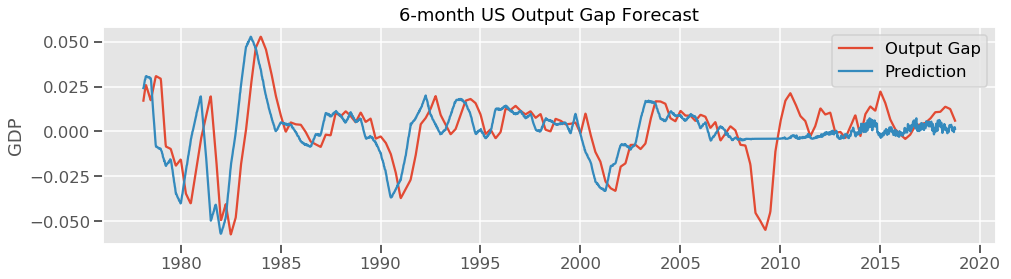

In [78]:
pred = pd.DataFrame(svm.predict((X_pca_gap[:, :n_pc])))
pred.set_index(X.index, inplace=True)
pred.columns = ["pred"]
fig = plt.figure(figsize=(16,4))
ax = plt.plot(pd.merge(df_merged.gap[X_scaled.index], pred, on="date"))
plt.title("6-month US Output Gap Forecast")
plt.ylabel("GDP")
plt.legend(["Output Gap", "Prediction"])
plt.savefig("../images/6m_gap_svm")
plt.show()

In [79]:
# tscv = TimeSeriesSplit(n_splits=5)
# i = 1
# score_dict = {}
# for train_index, test_index in tscv.split(X_train):
#     X_tr, X_tst = X_train[train_index], X_train[test_index]
#     y_tr, y_tst = g12m_train[train_index], g12m_train[test_index]
#     score = 0
#     for mf in np.linspace(10, 100, 10):
#         for ne in np.linspace(10, 30, 11):
#             for md in np.linspace(5, 25, 11):
#                 for msl in np.linspace(10, 40, 16):
#                     rfr = RandomForestRegressor(max_features=int(mf),
#                                                 n_estimators=int(ne), 
#                                                 max_depth=int(md),
#                                                 min_samples_leaf=int(msl)
#                                                )
#                     rfr.fit(X_tr, y_tr)
#                     if score < rfr.score(X_tst, y_tst):
#                         score_dict[i] = [mf, ne, md, msl, rfr.score(X_tst, y_tst)]
#     i += 1

In [80]:
# score_dict

In [81]:
rfr = RandomForestRegressor(max_features=50,
                            n_estimators=50, 
                            max_depth=20, 
                            min_samples_leaf=30,
                            random_state=0
                           )
rfr.fit(X_train_gap, g6m_train)
print("train: ", rfr.score(X_train_gap, g6m_train))
print("test: ", rfr.score(X_test_gap, g6m_test))

train:  0.848984907248231
test:  0.5785821357521631


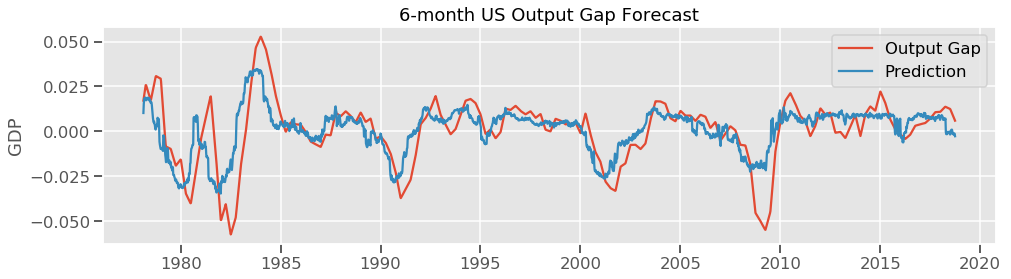

In [82]:
pred = pd.DataFrame(rfr.predict((X_pca_gap[:, :n_pc])))
pred.set_index(X.index, inplace=True)
pred.columns = ["pred"]
fig = plt.figure(figsize=(16,4))
ax = plt.plot(pd.merge(df_merged.gap[X_scaled.index], pred, on="date"))
plt.title("6-month US Output Gap Forecast")
plt.ylabel("GDP")
plt.legend(["Output Gap", "Prediction"])
plt.savefig("../images/6m_gap_rfr")
plt.show()

In [83]:
xgr = XGBRegressor(max_depth=3, 
                   min_child_weight=20,
                   gamma=0,
                   subsample=0.95,
                   colsample_bytree=1,
                   learning_rate=0.3, 
                   n_estimators=200,
                   reg_alpha=0.001,
                   random_state=0
                  )
xgr.fit(X_train_gap,
        g6m_train,
        eval_set=[(X_train_gap, g6m_train), (X_test_gap, g6m_test)],
        early_stopping_rounds=10,
        verbose=False)
print("train", xgr.score(X_train_gap, g6m_train))
print("test", xgr.score(X_test_gap, g6m_test))

/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[13:44:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
train 0.9529589393198655
test 0.5243961565780241


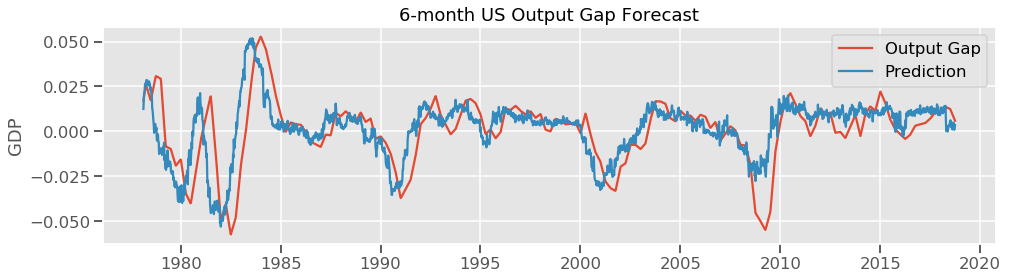

In [84]:
pred = pd.DataFrame(xgr.predict((X_pca_gap[:, :n_pc])))
pred.set_index(X.index, inplace=True)
pred.columns = ["pred"]
fig = plt.figure(figsize=(16,4))
ax = plt.plot(pd.merge(df_merged.gap[X_scaled.index], pred, on="date"))
plt.title("6-month US Output Gap Forecast")
plt.ylabel("GDP")
plt.legend(["Output Gap", "Prediction"])
plt.savefig("../images/6m_gap_xgr")
plt.show()

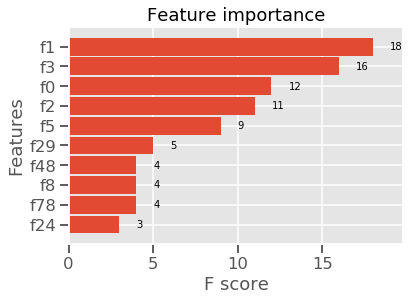

In [85]:
plot_importance(xgr, height=0.9, max_num_features=10)
plt.show()

In [86]:
svm = SVR(C=50, 
          epsilon=10**-7, 
          gamma="auto")
svm.fit(X_train_gap, g12m_train)
print("train", svm.score(X_train_gap, g12m_train))
print("test", svm.score(X_test_gap, g12m_test))

train 0.9998260162500537
test 0.07429876307871874


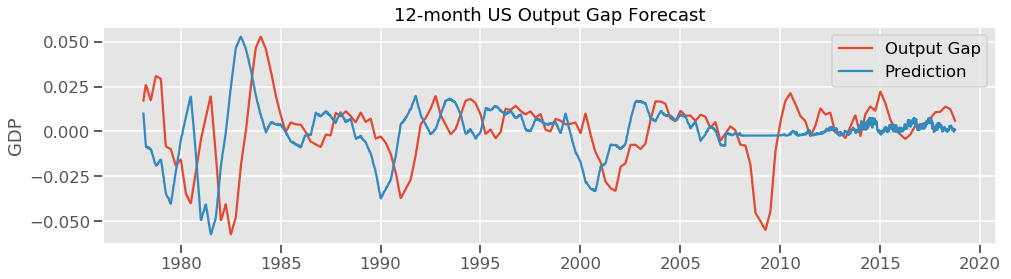

In [87]:
pred = pd.DataFrame(svm.predict((X_pca_gap[:, :n_pc])))
pred.set_index(X.index, inplace=True)
pred.columns = ["pred"]
fig = plt.figure(figsize=(16,4))
ax = plt.plot(pd.merge(df_merged.gap[X_scaled.index], pred, on="date"))
plt.title("12-month US Output Gap Forecast")
plt.ylabel("GDP")
plt.legend(["Output Gap", "Prediction"])
plt.savefig("../images/12m_gap_svm")
plt.show()

In [88]:
# tscv = TimeSeriesSplit(n_splits=5)
# i = 1
# score_dict = {}
# for train_index, test_index in tscv.split(X_train):
#     X_tr, X_tst = X_train[train_index], X_train[test_index]
#     y_tr, y_tst = g12m_train[train_index], g12m_train[test_index]
#     score = 0
#     for mf in np.linspace(10, 100, 10):
#         for ne in np.linspace(10, 30, 11):
#             for md in np.linspace(5, 25, 11):
#                 for msl in np.linspace(10, 40, 16):
#                     rfr = RandomForestRegressor(max_features=int(mf),
#                                                 n_estimators=int(ne), 
#                                                 max_depth=int(md),
#                                                 min_samples_leaf=int(msl)
#                                                )
#                     rfr.fit(X_tr, y_tr)
#                     if score < rfr.score(X_tst, y_tst):
#                         score_dict[i] = [mf, ne, md, msl, rfr.score(X_tst, y_tst)]
#     i += 1

In [89]:
# score_dict

In [90]:
rfr = RandomForestRegressor(max_features=50,
                            n_estimators=50, 
                            max_depth=20, 
                            min_samples_leaf=30,
                            random_state=0
                           )
rfr.fit(X_train_gap, g12m_train)
print("train: ", rfr.score(X_train_gap, g12m_train))
print("test: ", rfr.score(X_test_gap, g12m_test))

train:  0.7533819386051154
test:  0.2163414209879574


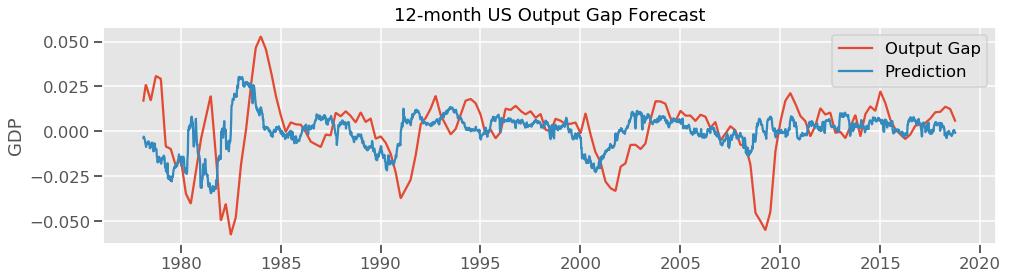

In [91]:
pred = pd.DataFrame(rfr.predict((X_pca_gap[:, :n_pc])))
pred.set_index(X.index, inplace=True)
pred.columns = ["pred"]
fig = plt.figure(figsize=(16,4))
ax = plt.plot(pd.merge(df_merged.gap[X_scaled.index], pred, on="date"))
plt.title("12-month US Output Gap Forecast")
plt.ylabel("GDP")
plt.legend(["Output Gap", "Prediction"])
plt.savefig("../images/12m_gap_rfr")
plt.show()

In [92]:
xgr = XGBRegressor(max_depth=2, 
                   learning_rate=0.13, 
                   n_estimators=40)
xgr.fit(X_train_gap,
        g12m_train)
print("train", xgr.score(X_train_gap, g12m_train))
print("test", xgr.score(X_test_gap, g12m_test))

/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[13:44:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
train 0.7606870858785528
test 0.04821971372245504


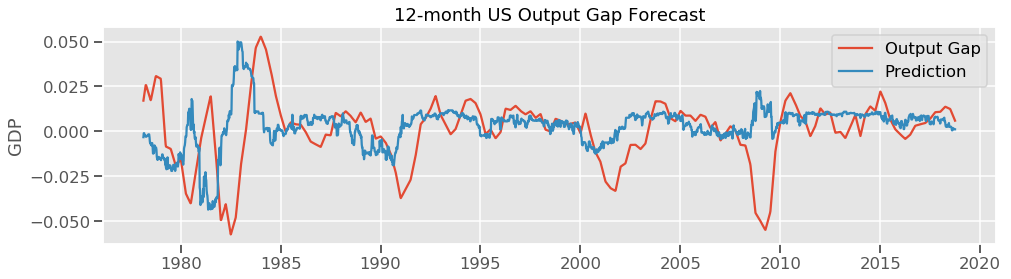

In [93]:
pred = pd.DataFrame(xgr.predict((X_pca_gap[:, :n_pc])))
pred.set_index(X.index, inplace=True)
pred.columns = ["pred"]
fig = plt.figure(figsize=(16,4))
ax = plt.plot(pd.merge(df_merged.gap[X_scaled.index], pred, on="date"))
plt.title("12-month US Output Gap Forecast")
plt.ylabel("GDP")
plt.legend(["Output Gap", "Prediction"])
plt.savefig("../images/12m_gap_xgr")
plt.show()